# CIFAR-10 图像分类

使用自己实现的神经网络框架进行训练

CIFAR-10是32x32的彩色图像数据集，包含10个类别，比MNIST和Fashion-MNIST更复杂

In [1]:
# 导入神经网络框架的所有组件
from extracted_code import (
    Tensor, Linear, Sequential, ReLUModule,
    Module, SGD, Adam, Flatten, Parameter
)
import numpy as np
import os
import urllib.request


network

In [2]:
# 定义CIFAR-10分类器模型
# CIFAR-10: 32x32x3 (RGB彩色图像)
class CIFAR10Classifier(Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.network = Sequential(
            Linear(32 * 32 * 3, 256),  # 输入: 3072 (32*32*3)
            ReLUModule(),
            Linear(256, 128),
            ReLUModule(),
            Linear(128, 64),
            ReLUModule(),
            Linear(64, 10)  # 输出: 10个类别
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

data loading

In [3]:
import pickle
import tarfile

# CIFAR-10类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 自动下载CIFAR-10数据集
def download_cifar10():
    """如果文件不存在，自动下载CIFAR-10数据集"""
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    
    if not os.path.exists(filename):
        print(f"正在下载 {filename}...")
        print("这可能需要几分钟，请耐心等待...")
        try:
            urllib.request.urlretrieve(url, filename)
            print(f"  ✓ {filename} 下载完成")
        except Exception as e:
            print(f"  ✗ 下载失败: {e}")
            print(f"  请手动下载: {url}")
            raise
    
    # 解压文件
    if not os.path.exists('cifar-10-batches-py'):
        print("正在解压文件...")
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
        print("  ✓ 解压完成")

# 加载CIFAR-10数据集
def load_cifar10_batch(filepath):
    """加载CIFAR-10的一个batch"""
    with open(filepath, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        images = batch['data'].reshape(len(batch['data']), 3, 32, 32)
        images = images.transpose(0, 2, 3, 1)  # 转换为 (N, H, W, C)
        labels = np.array(batch['labels'])
        return images.astype('float32') / 255.0, labels.astype('int32')

def load_cifar10():
    """加载完整的CIFAR-10数据集"""
    train_images_list = []
    train_labels_list = []
    
    # 加载训练数据 (5个batch)
    for i in range(1, 6):
        filepath = f'cifar-10-batches-py/data_batch_{i}'
        images, labels = load_cifar10_batch(filepath)
        train_images_list.append(images)
        train_labels_list.append(labels)
    
    train_images = np.concatenate(train_images_list, axis=0)
    train_labels = np.concatenate(train_labels_list, axis=0)
    
    # 加载测试数据
    test_images, test_labels = load_cifar10_batch('cifar-10-batches-py/test_batch')
    
    return train_images, train_labels, test_images, test_labels

print("加载CIFAR-10数据集...")
print("类别: ", class_names)
# 检查并下载数据文件
download_cifar10()

try:
    train_images, train_labels, test_images, test_labels = load_cifar10()
    
    print(f"原始训练集: {train_images.shape[0]} 个样本, 形状: {train_images.shape[1:]} (H, W, C)")
    print(f"原始测试集: {test_images.shape[0]} 个样本, 形状: {test_images.shape[1:]} (H, W, C)")
    
    # 使用部分数据进行快速训练
    train_size = 10000
    test_size = 2000
    train_images = train_images[:train_size]
    train_labels = train_labels[:train_size]
    test_images = test_images[:test_size]
    test_labels = test_labels[:test_size]
    
    print(f"使用训练集: {train_size} 个样本")
    print(f"使用测试集: {test_size} 个样本")
except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e}")
    print("请确保数据文件在当前目录")
    raise

加载CIFAR-10数据集...
类别:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
原始训练集: 50000 个样本, 形状: (32, 32, 3) (H, W, C)
原始测试集: 10000 个样本, 形状: (32, 32, 3) (H, W, C)
使用训练集: 10000 个样本
使用测试集: 2000 个样本


training

In [ ]:
# ==================== 训练准备 ====================

# 定义softmax和交叉熵损失函数
def softmax(x):
    """Softmax激活函数"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(logits, labels):
    """交叉熵损失"""
    batch_size = len(labels)
    logits_data = logits.realize_cached_data()
    
    # Softmax
    probs = softmax(logits_data)
    
    # 交叉熵
    log_likelihood = -np.log(probs[range(batch_size), labels] + 1e-10)
    loss = np.mean(log_likelihood)
    
    # 梯度: softmax - one_hot
    grad = probs.copy()
    grad[range(batch_size), labels] -= 1
    grad = grad / batch_size
    
    return loss, Tensor(grad, requires_grad=False)

# 梯度裁剪函数
def clip_gradients(params, max_norm=1.0):
    """裁剪梯度以防止梯度爆炸"""
    total_norm = 0.0
    for p in params:
        if p.grad is not None:
            grad_data = p.grad.realize_cached_data()
            total_norm += np.sum(grad_data ** 2)
    total_norm = np.sqrt(total_norm)
    
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for p in params:
            if p.grad is not None:
                p.grad.cached_data = p.grad.realize_cached_data() * clip_coef
    return total_norm

# 创建模型
model = CIFAR10Classifier()
print("模型架构:")
print("  输入层:  3072 (32x32x3 RGB)")
print("  隐藏层1: 256 + ReLU")
print("  隐藏层2: 128 + ReLU")
print("  隐藏层3: 64 + ReLU")
print("  输出层:  10 (图像类别)")
print("  类别: ", class_names)

total_params = sum(p.realize_cached_data().size for p in model.parameters())
print(f"\n总参数数量: {total_params:,}")

# 训练参数
learning_rate = 0.001
batch_size = 64
epochs = 30 

# 创建优化器
optimizer = Adam(model.parameters(), lr=learning_rate)

print(f"\n优化器: Adam")
print(f"学习率: {learning_rate}")
print(f"批次大小: {batch_size}")
print(f"训练轮数: {epochs}")

模型架构:
  输入层:  3072 (32x32x3 RGB)
  隐藏层1: 256 + ReLU
  隐藏层2: 128 + ReLU
  隐藏层3: 64 + ReLU
  输出层:  10 (图像类别)
  类别:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

总参数数量: 828,490

优化器: Adam
学习率: 0.001
批次大小: 64
训练轮数: 30


In [5]:
# ==================== 训练循环 ====================

train_losses = []
train_accs = []
test_accs = []

print("\n开始训练...")
print("=" * 70)

for epoch in range(epochs):
    # 训练阶段
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    # 随机打乱训练数据
    indices = np.random.permutation(len(train_images))
    train_images_shuffled = train_images[indices]
    train_labels_shuffled = train_labels[indices]
    
    # Mini-batch训练
    num_batches = len(train_images) // batch_size
    
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        
        batch_images = train_images_shuffled[start:end]
        batch_labels = train_labels_shuffled[start:end]
        
        # 前向传播
        # CIFAR-10: (batch_size, 32, 32, 3)
        X = Tensor(batch_images, requires_grad=False)
        pred = model(X)
        
        # 计算损失
        loss, loss_grad = cross_entropy_loss(pred, batch_labels)
        epoch_loss += loss
        
        # 反向传播
        optimizer.zero_grad()
        pred.backward(loss_grad)
        
        # 梯度裁剪
        grad_norm = clip_gradients(model.parameters(), max_norm=5.0)
        
        # 更新参数
        optimizer.step()
        
        # 计算准确率
        pred_data = pred.realize_cached_data()
        pred_labels = np.argmax(pred_data, axis=1)
        correct += np.sum(pred_labels == batch_labels)
        total += batch_size
    
    avg_loss = epoch_loss / num_batches
    train_acc = 100.0 * correct / total
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    
    # 测试阶段
    model.eval()
    test_pred = model(Tensor(test_images, requires_grad=False))
    test_pred_data = test_pred.realize_cached_data()
    test_pred_labels = np.argmax(test_pred_data, axis=1)
    test_acc = 100.0 * np.sum(test_pred_labels == test_labels) / len(test_labels)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

print("\n训练完成!")
print(f"最终训练准确率: {train_accs[-1]:.2f}%")
print(f"最终测试准确率:  {test_accs[-1]:.2f}%")


开始训练...
Epoch  1/30 | Loss: 2.0792 | Train Acc: 23.81% | Test Acc: 30.20%
Epoch  2/30 | Loss: 1.8987 | Train Acc: 30.57% | Test Acc: 31.85%
Epoch  3/30 | Loss: 1.8083 | Train Acc: 34.28% | Test Acc: 36.25%
Epoch  4/30 | Loss: 1.7476 | Train Acc: 37.24% | Test Acc: 35.60%
Epoch  5/30 | Loss: 1.7105 | Train Acc: 38.82% | Test Acc: 38.20%
Epoch  6/30 | Loss: 1.6734 | Train Acc: 39.68% | Test Acc: 35.55%
Epoch  7/30 | Loss: 1.6478 | Train Acc: 41.02% | Test Acc: 39.25%
Epoch  8/30 | Loss: 1.6108 | Train Acc: 42.28% | Test Acc: 40.35%
Epoch  9/30 | Loss: 1.5789 | Train Acc: 43.22% | Test Acc: 41.45%
Epoch 10/30 | Loss: 1.5410 | Train Acc: 45.46% | Test Acc: 40.30%
Epoch 11/30 | Loss: 1.5189 | Train Acc: 45.08% | Test Acc: 37.65%
Epoch 12/30 | Loss: 1.4903 | Train Acc: 46.48% | Test Acc: 42.00%
Epoch 13/30 | Loss: 1.4688 | Train Acc: 47.71% | Test Acc: 44.95%
Epoch 14/30 | Loss: 1.4273 | Train Acc: 48.77% | Test Acc: 43.25%
Epoch 15/30 | Loss: 1.4128 | Train Acc: 49.57% | Test Acc: 38.55%
E

testing and visualization


生成可视化结果...
结果已保存到: cifar10_training_results.png


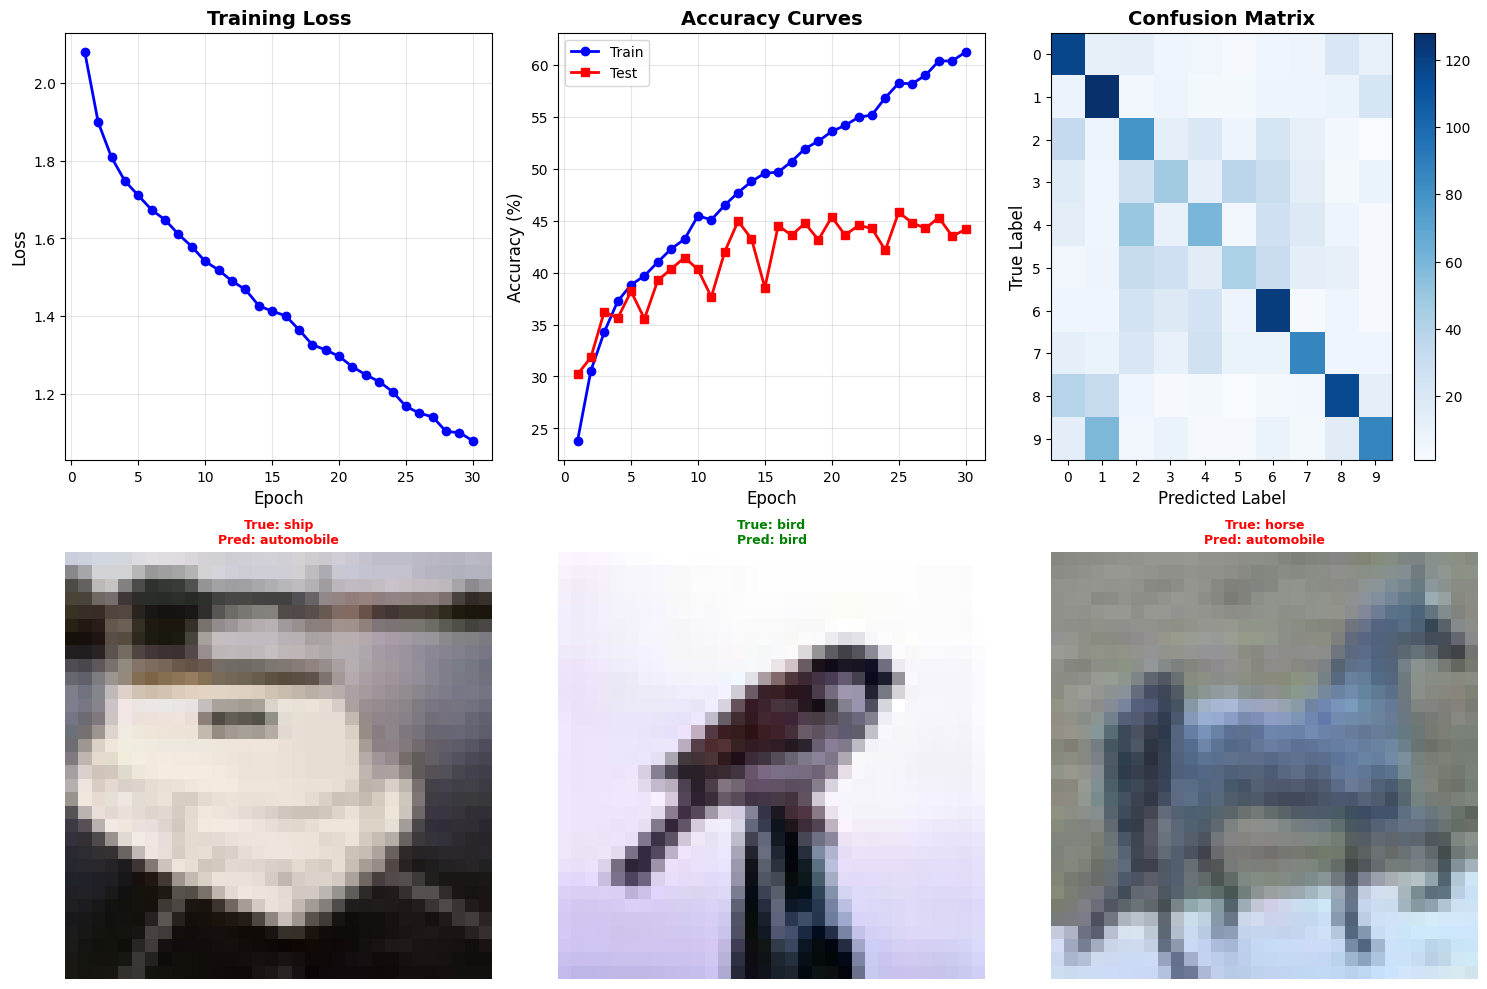

In [6]:
# ==================== 可视化结果 ====================
import matplotlib.pyplot as plt
from collections import defaultdict

print("\n生成可视化结果...")

fig = plt.figure(figsize=(15, 10))

# 1. 训练曲线
ax1 = plt.subplot(2, 3, 1)
ax1.plot(range(1, epochs+1), train_losses, 'b-', linewidth=2, marker='o')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. 准确率曲线
ax2 = plt.subplot(2, 3, 2)
ax2.plot(range(1, epochs+1), train_accs, 'b-', linewidth=2, marker='o', label='Train')
ax2.plot(range(1, epochs+1), test_accs, 'r-', linewidth=2, marker='s', label='Test')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. 混淆矩阵
confusion = defaultdict(int)
for true, pred in zip(test_labels, test_pred_labels):
    confusion[(true, pred)] += 1

confusion_matrix = np.zeros((10, 10))
for (true, pred), count in confusion.items():
    confusion_matrix[true, pred] = count

ax3 = plt.subplot(2, 3, 3)
im = ax3.imshow(confusion_matrix, cmap='Blues', aspect='auto')
ax3.set_xlabel('Predicted Label', fontsize=12)
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_xticks(range(10))
ax3.set_yticks(range(10))
plt.colorbar(im, ax=ax3)

# 4-6. 预测示例
np.random.seed(42)
sample_indices = np.random.choice(len(test_images), 3, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    ax = plt.subplot(2, 3, idx+4)
    img = test_images[sample_idx]  # CIFAR-10已经是 (32, 32, 3) 格式
    true_label = test_labels[sample_idx]
    pred_label = test_pred_labels[sample_idx]
    
    ax.imshow(img)  # CIFAR-10是彩色图像，不需要cmap='gray'
    ax.axis('off')
    
    color = 'green' if pred_label == true_label else 'red'
    true_name = class_names[true_label]
    pred_name = class_names[pred_label]
    ax.set_title(f'True: {true_name}\nPred: {pred_name}',
                 color=color, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('cifar10_training_results.png', dpi=150, bbox_inches='tight')
print("结果已保存到: cifar10_training_results.png")
plt.show()